# R processing and plotting of phylogentic output






<br>


## Overview



In the previous tutorial, we used IQ-TREE and SVDQuartets to estimate phylogenetic trees from the alignments we assembled with ipyrad in the first tutorial. The output from these are text representations of phylogenies, which we'll need to plot to make sense of. There are various programs that be used to visualize trees. [FigTree](https://tree.bio.ed.ac.uk/software/figtree/) is a popular GUI-based, interactive program, but to make customizable, publication-quality phylogenetic graphics, it's hard to beat the options available in R. Using R, we can plot and manipulate phylogenies, plot the to maps, and even combine them with the population clsutering results from the second tutorial.



## Learning objectives

1. Learn to plot and manipulate phylogenetic trees in R
2. Combine phylogenies with population genetic clustering results



## Prerequisites

All necessary software is included in the container that we will use on Google Cloud: `us-east4-docker.pkg.dev/nih-cl-shared-resources/nigms-sandbox/nigms-vertex-r-wy`

If you are not using the container, you will need to install the following software:

- **R**: This notebook runs in an R kernel
- **R packages**: The following R packages are required:
    - ape
    - phytools
    - LEA
    - vcfR
    - plotrix


<br>
<br>


# Get started

<br>



## Setup

### Data download

If you successfully ran through the previous tutorials in the same Google Cloud instance that you are running this notebook from, then you should have all necessary files to start this notebook.


If you did not run through the previous tutorial or are running this tutorial from a fresh instance, you can download the ipyrad output we provide in the "radseq_cloud" Google bucket. Only uncomment and run these next lines if you want to download the ipyrad assembly.

In [1]:
# system("gsutil -m cp -r gs://radseq_cloud/ .", intern = TRUE)
# system("mkdir -p ./ipyrad_out/ruber_reduced_denovo_outfiles/")
# system("cp ./radseq_cloud/ruber-ipyrad-out/* ipyrad_out/ruber_reduced_denovo_outfiles/", intern = TRUE)

As in the population genetics tutorial, load up the packages we'll use. If you are not using the container we've provided, you'll need to install these yourself by uncommenting the commented portions. 


In [2]:
# # Install packages, uncomment if necessary:
# install.packages(c("ape", "phytools", "vcfR", "plotrix", "BiocManager"))
# BiocManager::install("LEA")



# load necessary packages
library(ape)
library(phytools)
library(LEA)
library(vcfR)
library(plotrix)
library(IRdisplay)

Loading required package: maps


   *****       ***   vcfR   ***       *****
   This is vcfR 1.15.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘plotrix’


The following object is masked from ‘package:phytools’:

    rescale




## Plotting IQ-TREE output


As usual, let's set up some objects that contain paths so these aren't hard coded into functions and the script can be easily modified for other datasets. Be sure to modify the path depending on if you ran the previous tutorials or merely copied the inputs in - the paths as specified should work if you have run through the previous tutorials as written.

In [3]:
# Load up the paths we need

iq_file <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/iqtree_out/ruber.treefile"
coords <- read.csv("/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/population-genomics/ruber_data/Localities.csv", header=TRUE, row.names=NULL) # path to the geographic coordinates for the samples


Then we can start by using some functions from the `ape` package to read and plot the tree:

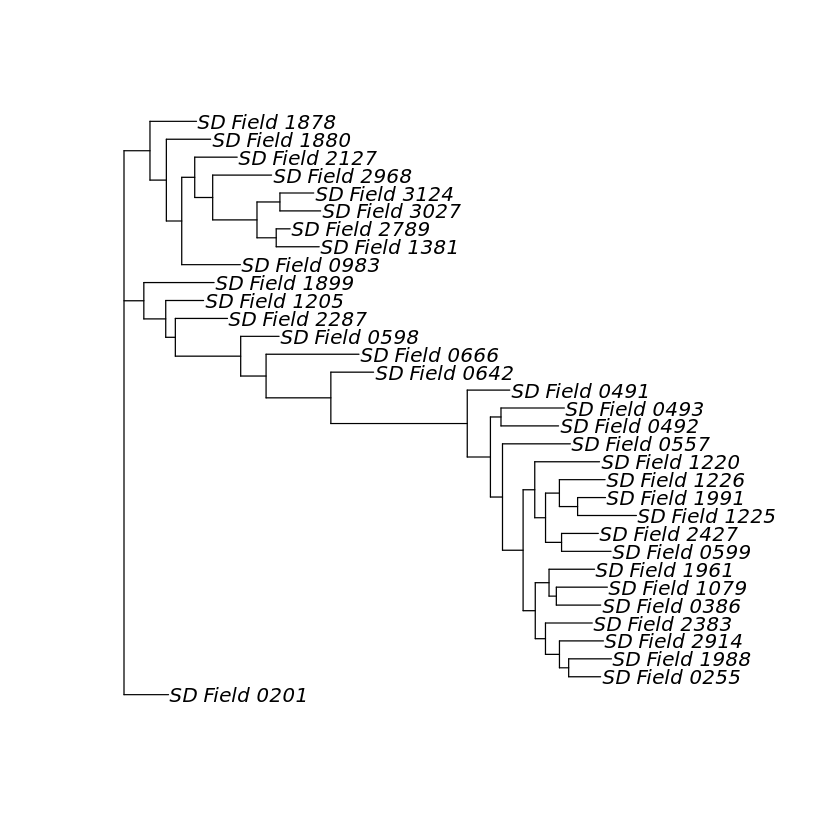

In [4]:
#plot IQTree

iq_tree <- read.tree(iq_file)

# Use functions from ape to plot the tree

plot.phylo(iq_tree) # plot the tree

As is, this isn't easy to interpret:



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/iq_tree1.png" width=35% />
</details>

<br>


To start, IQtree generates an unrooted tree, so we need to do some manipulation to put the root where it should be. This will be true of most phylogenetic inference programs if they do not include a clock model.

Usually, we would include outgroup taxa in the tree to know where the root goes. Since we removed all of the outgroups in one of our ipyrad branching steps, we'll root the tree based on the published tree from [Harrington et al. 2018](https://onlinelibrary.wiley.com/doi/full/10.1111/jbi.13114).

We want the root to separate the tree into two clades: 

- One that contains `SD Field 0666`, `SD Field 0598`, `SD Field 0201` and other samples from this node
and
- One that contains `SD Field 0642`, `SD Field 0491`, `SD Field 0255` and other samples from this node

The easiest way to do this is going to be to find the node that specifies one of these clades and place the root there. We'll use an `ape` package function to find the node representing the most recent common ancestor (MRCA) of `SD_Field_0642` and `SD_Field_0255` and then root on that node.

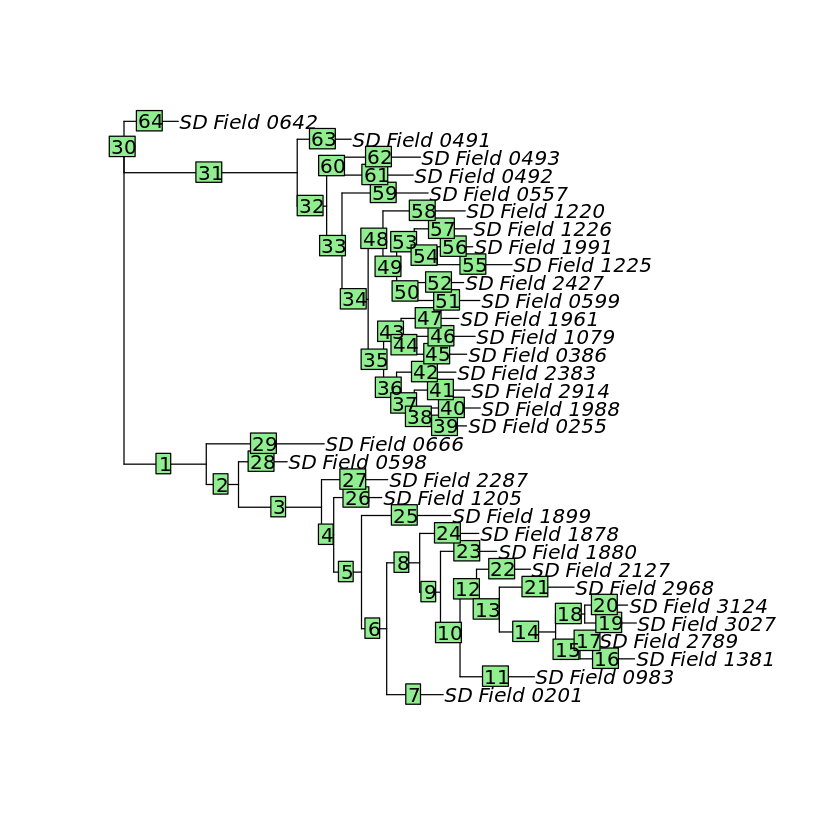

In [5]:
# Specify the taxa for the "outgroup"
taxa <- c("SD_Field_0642", "SD_Field_0255")

# Get the MRCA outgroup node
mrca_node <- getMRCA(iq_tree, taxa)

# Root the tree at the MRCA outgroup node
rooted_tree <- root(iq_tree, node = mrca_node, resolve.root = TRUE)

# Plot the rooted tree
plot(rooted_tree)
edgelabels() # add labels on the edges (branches) to get their indexes for the next step.

This is rooted correctly now, but we have a branch with length zero at the base of the tree. This is because there is no information about how to distribute the branch length at the root between the two daughter clades, and so the plotting defaults to just zero for the outgroup that was used to root.




<details>
  <summary>Click to show expected plot</summary>
  <img src="images/iq_tree2.png" width=50% />
</details>


<br>

We used `edgelabels()` in that last plot to get the indexes of each branch so that we can do some manual manipulation to make this prettier and distribute the length of the branch that connects the ingroup to the outgroup between the two of them. We can do this by identifying the branches we want to alter, and then assigning half of the branch length from the ingroup to the branch to the outgroup.

For me, the branch that unites SD Field 0642 with the rest of its clade is 30, and the node that defines the other clade at the root is 1. If your branches are different, you'll need to adjust these.

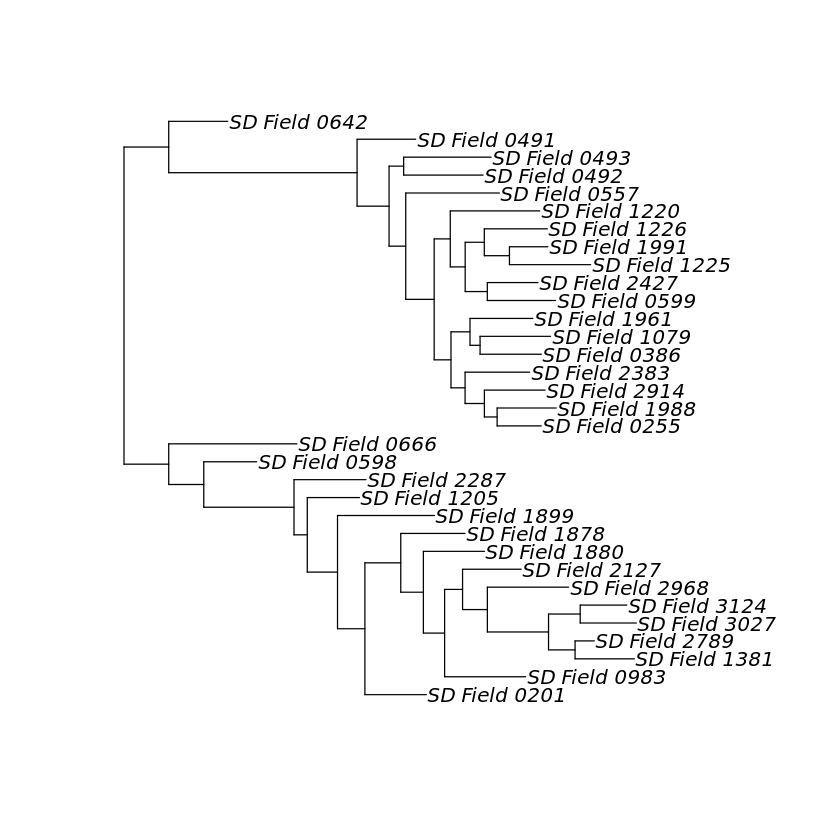

In [6]:
# take half of the length of edge 1 and assign it to the length of edge 30, which is zero right now


# Get the current length of edge 1
edge_1_length <- rooted_tree$edge.length[1]

# Halve the length of edge 1
new_edge_1_length <- edge_1_length / 2

# Get the current length of edge 30
edge_30_length <- rooted_tree$edge.length[30]

# Assign the new halved length to edge 1
rooted_tree$edge.length[1] <- new_edge_1_length

# Add the remaining length to edge 30
rooted_tree$edge.length[30] <- edge_30_length + (edge_1_length - new_edge_1_length)


plot(rooted_tree)


You should see something like this:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/iq_tree3.png" width=38% />
</details>

<br>

That looks much better and doesn't make it look like we have a polytomy at the root of the tree.



Next, we can add the support values to the nodes of the tree (bootstraps and SH-aLRT) so that we know how much confidence we should have in the accuracy of the inferred clades. There is more detail on these metrics of tree support and links to the papers that describe the SH-aLRT in the IQ-TREE introductory tutorial [here](http://www.iqtree.org/doc/Tutorial).

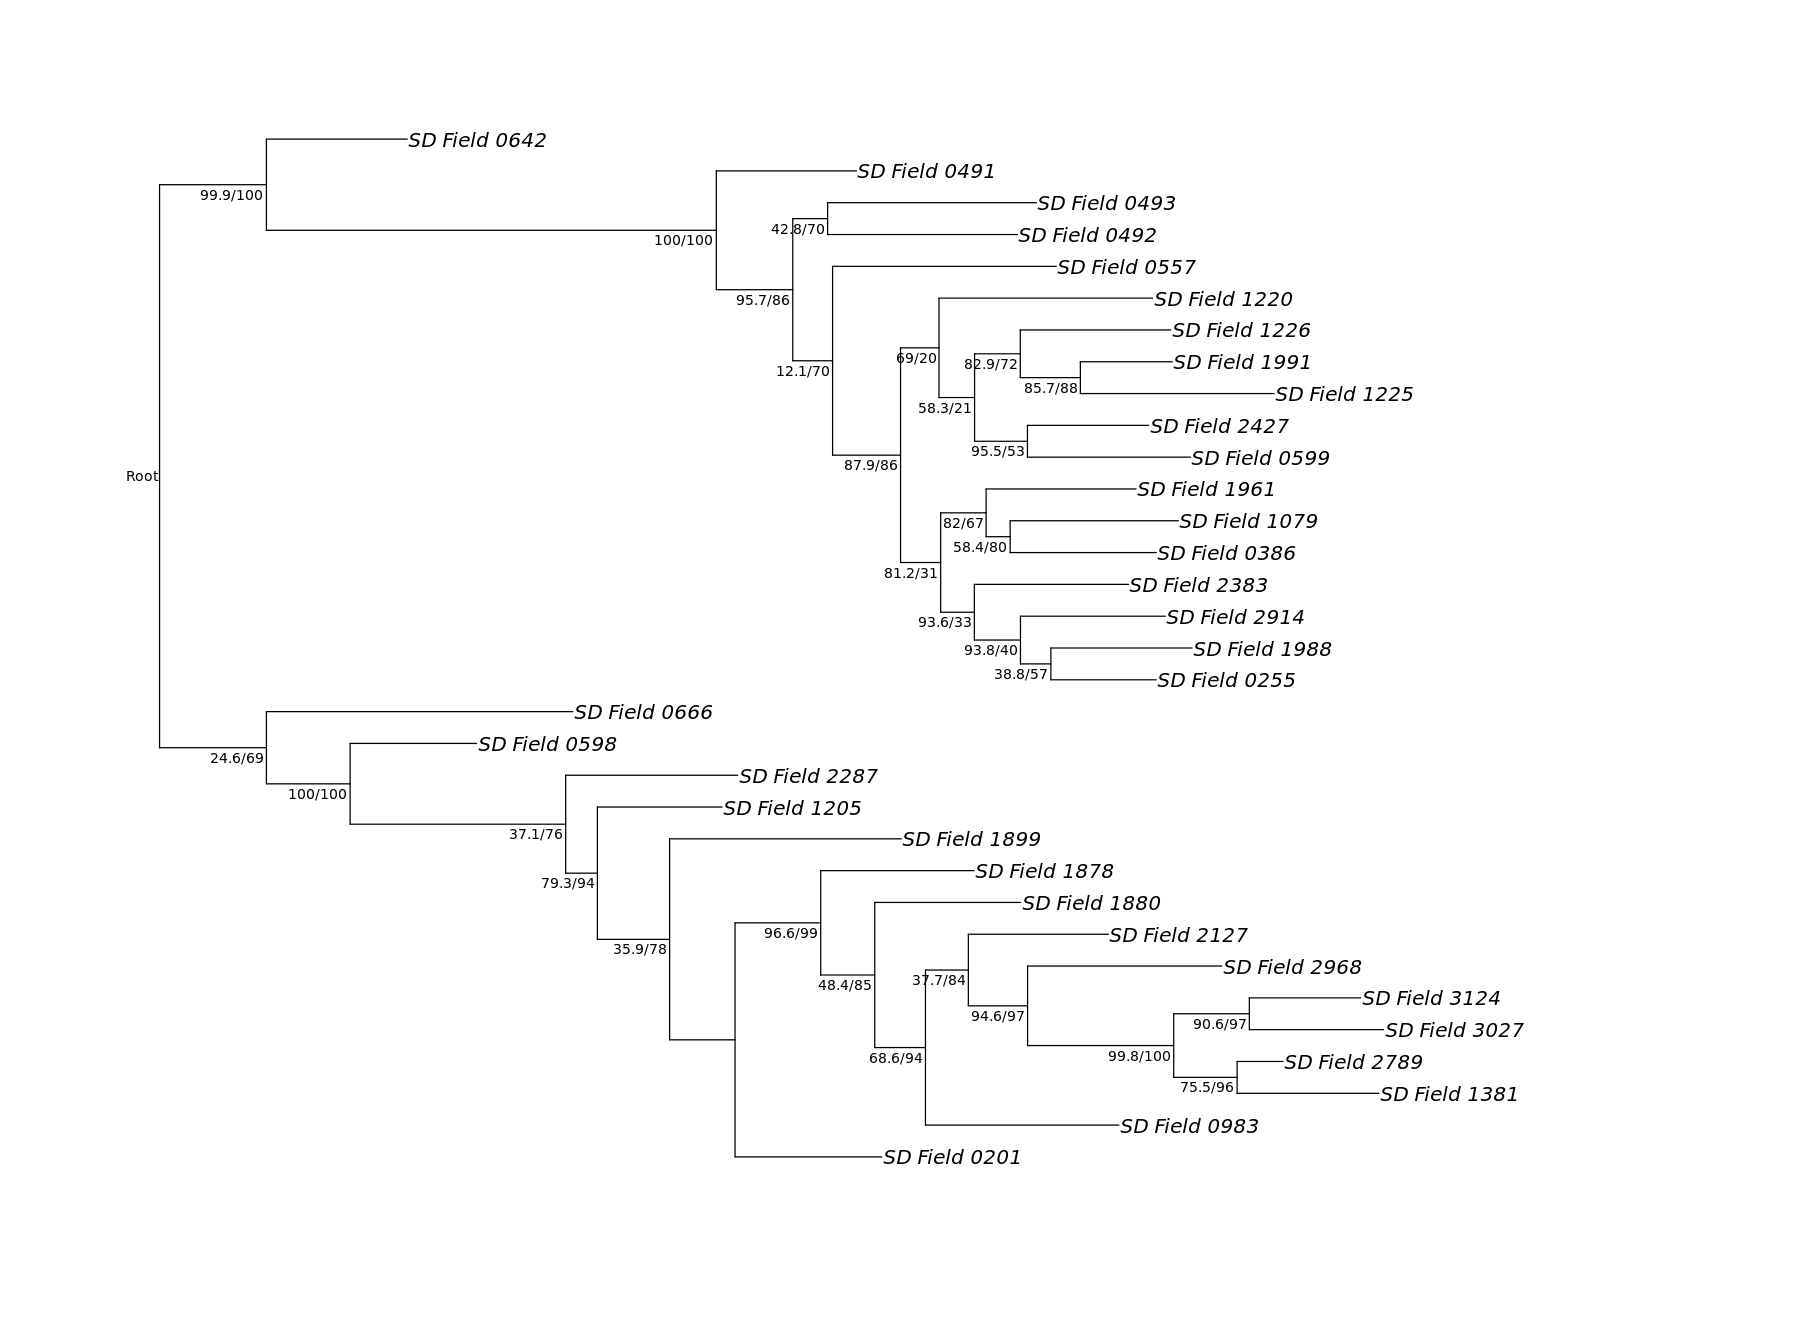

In [7]:
# Increase plot size for Jupyter
options(repr.plot.width = 15, repr.plot.height = 11)

plot(rooted_tree)
nodelabels(text = rooted_tree$node.label, adj = c(1.05, 1.5), cex = 0.7, frame = "none")

This should allow us to see the support values nicely:




<details>
  <summary>Click to show expected plot</summary>
  <img src="images/iq_tree4.png" width=70% />
</details>

<br>

Note that the root just has "Root" at it, because it contains all the taxa and there is nothing to assess support for.




<br>
<br>
<br>


## Plotting a tree to a map


We are often interested in visualizing how clades in the phylogenetic tree align with geographic regions or barriers. Plotting the tree onto a map is one convenient way of doing that for small to moderate phylogenies. We'll use the `phylo.to.map` function from the package `phytools` to plot our tree onto a map.




In [8]:
# some set up 

# Get the coordinates for just the individuals we want to plot and put in the same order as the tip labels - we read in the coordinates up top when we read in the tree file

ind_names <- rooted_tree$tip.label # get individual names from the tree
ind_names[which(!ind_names %in% coords[,"Field.No."])] # check if there are any individuals not in the coordinates


# match up the coordinates to the order of the individuals in the tree
match_coords <- match(ind_names, coords[,"Field.No."]) # get index of the coords that are in ind_names
tree_coords <- coords[match_coords,] # get just the coordinates for individuals in the tree in the order they show up in the tree
rownames(tree_coords) <- tree_coords[, "Field.No."] # for phylo.to.map, we need the individual names from the tree to be the row names of the coordinates, not a column
tree_coords <- tree_coords[, c("Latitude", "Longitude")] # make the tree_coords object only 2 columns, Latitude and Longitude

character(0)

objective: 528

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 162

objective: 158

objective: 156

objective: 156

objective: 154

objective: 136

objective: 122

objective: 100

objective: 98

objective: 94

objective: 58

objective: 58

objective: 58

objective: 58

objective: 58

objective: 56

objective: 56

objective: 56

objective: 56

objective: 54

objective: 52

objective: 50



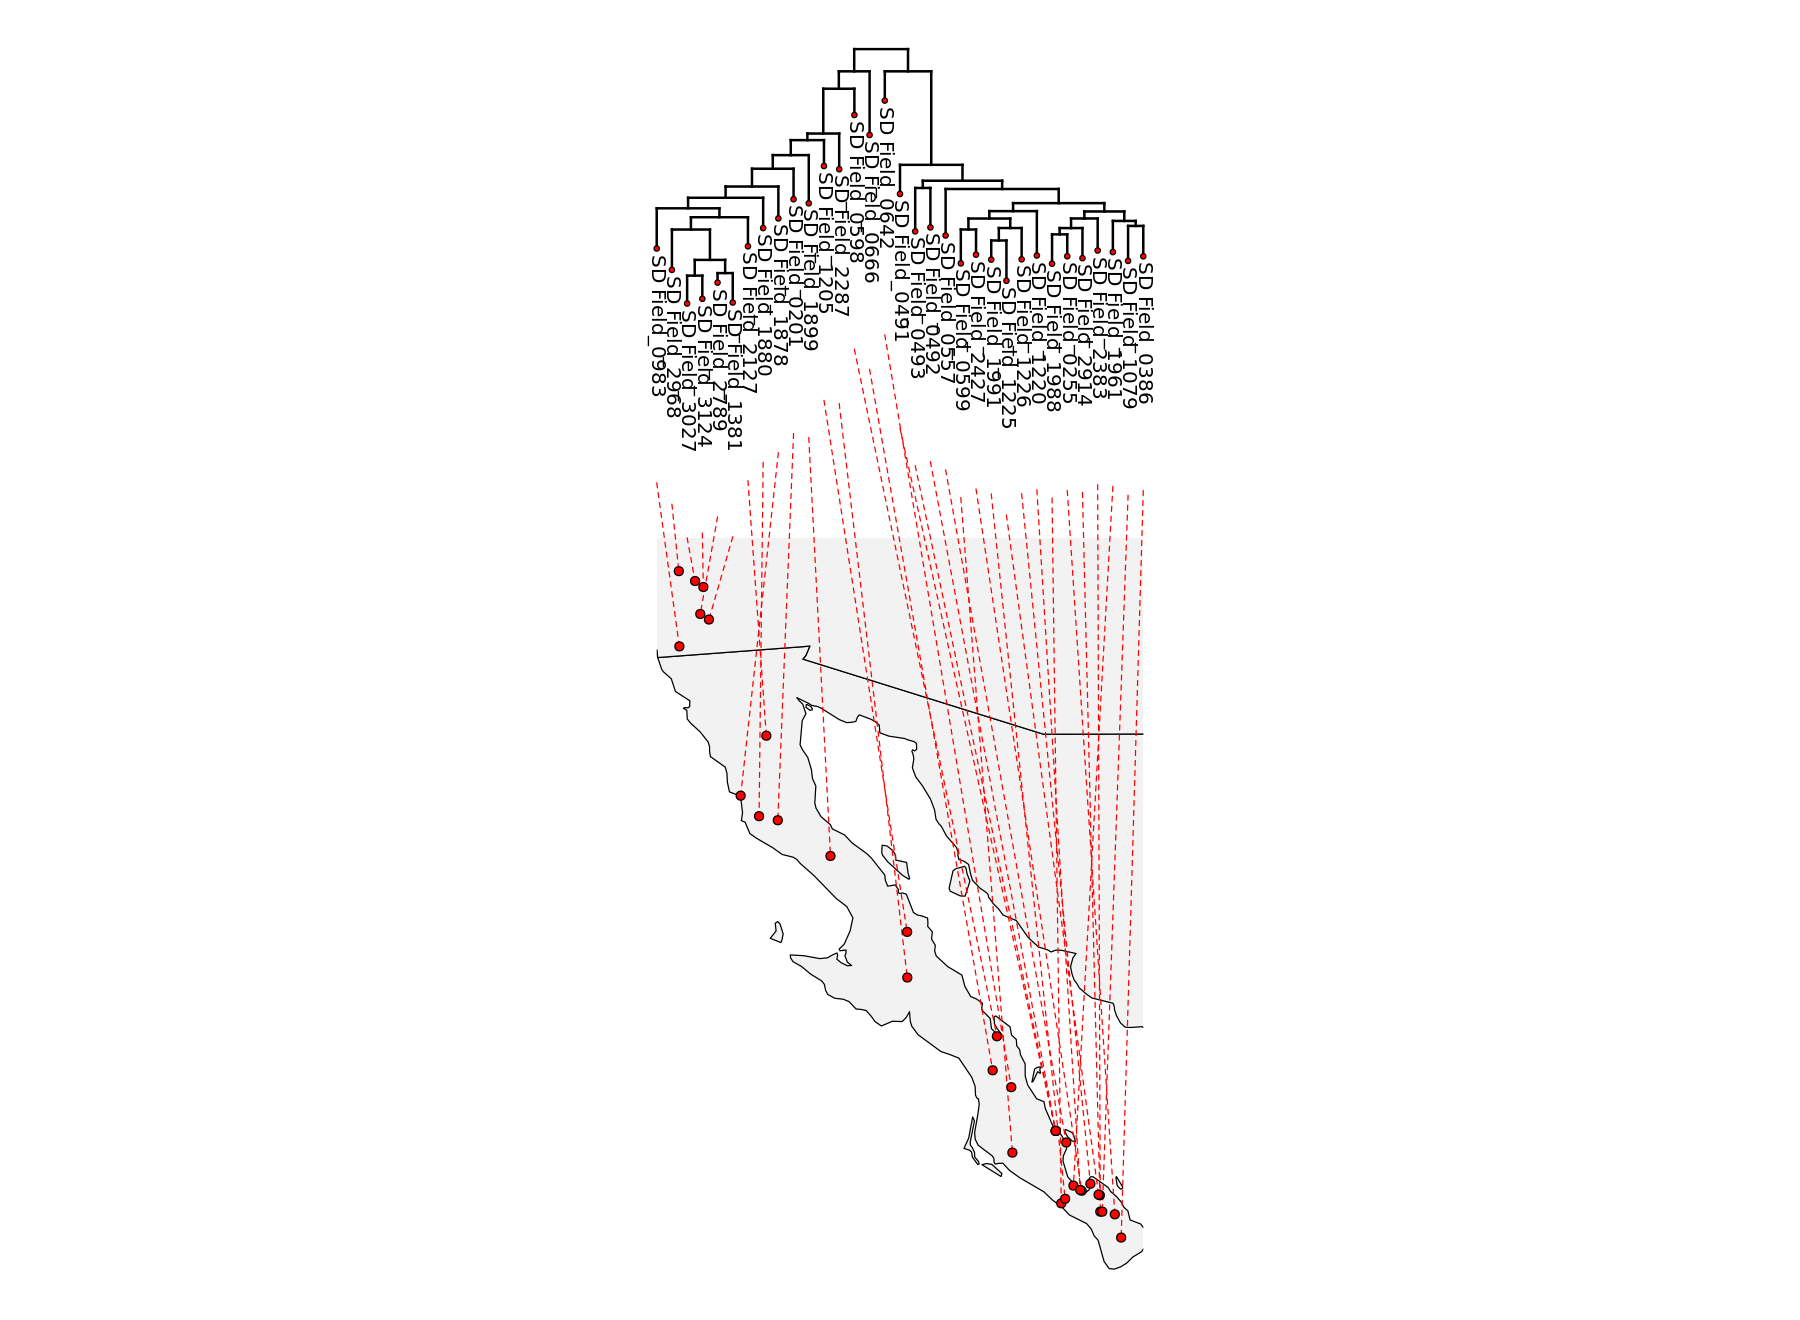

In [9]:
# Plot the tree to the map

phylo.to.map(rooted_tree, tree_coords)

Because our samples are on more of a north-south gradient than east-west, this default view isn't the best:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/phymap1.png" width=30% />
</details>




<br>
<br>

We can edit some options in `phylo.to.map` and make it much nicer:

objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 72

objective: 72

objective: 72

objective: 70

objective: 70

objective: 70

objective: 70

objective: 68

objective: 68

objective: 68

objective: 66

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 54

objective: 42

objective: 42

objective: 34

objective: 34

objective: 34

objective: 34

objective: 32



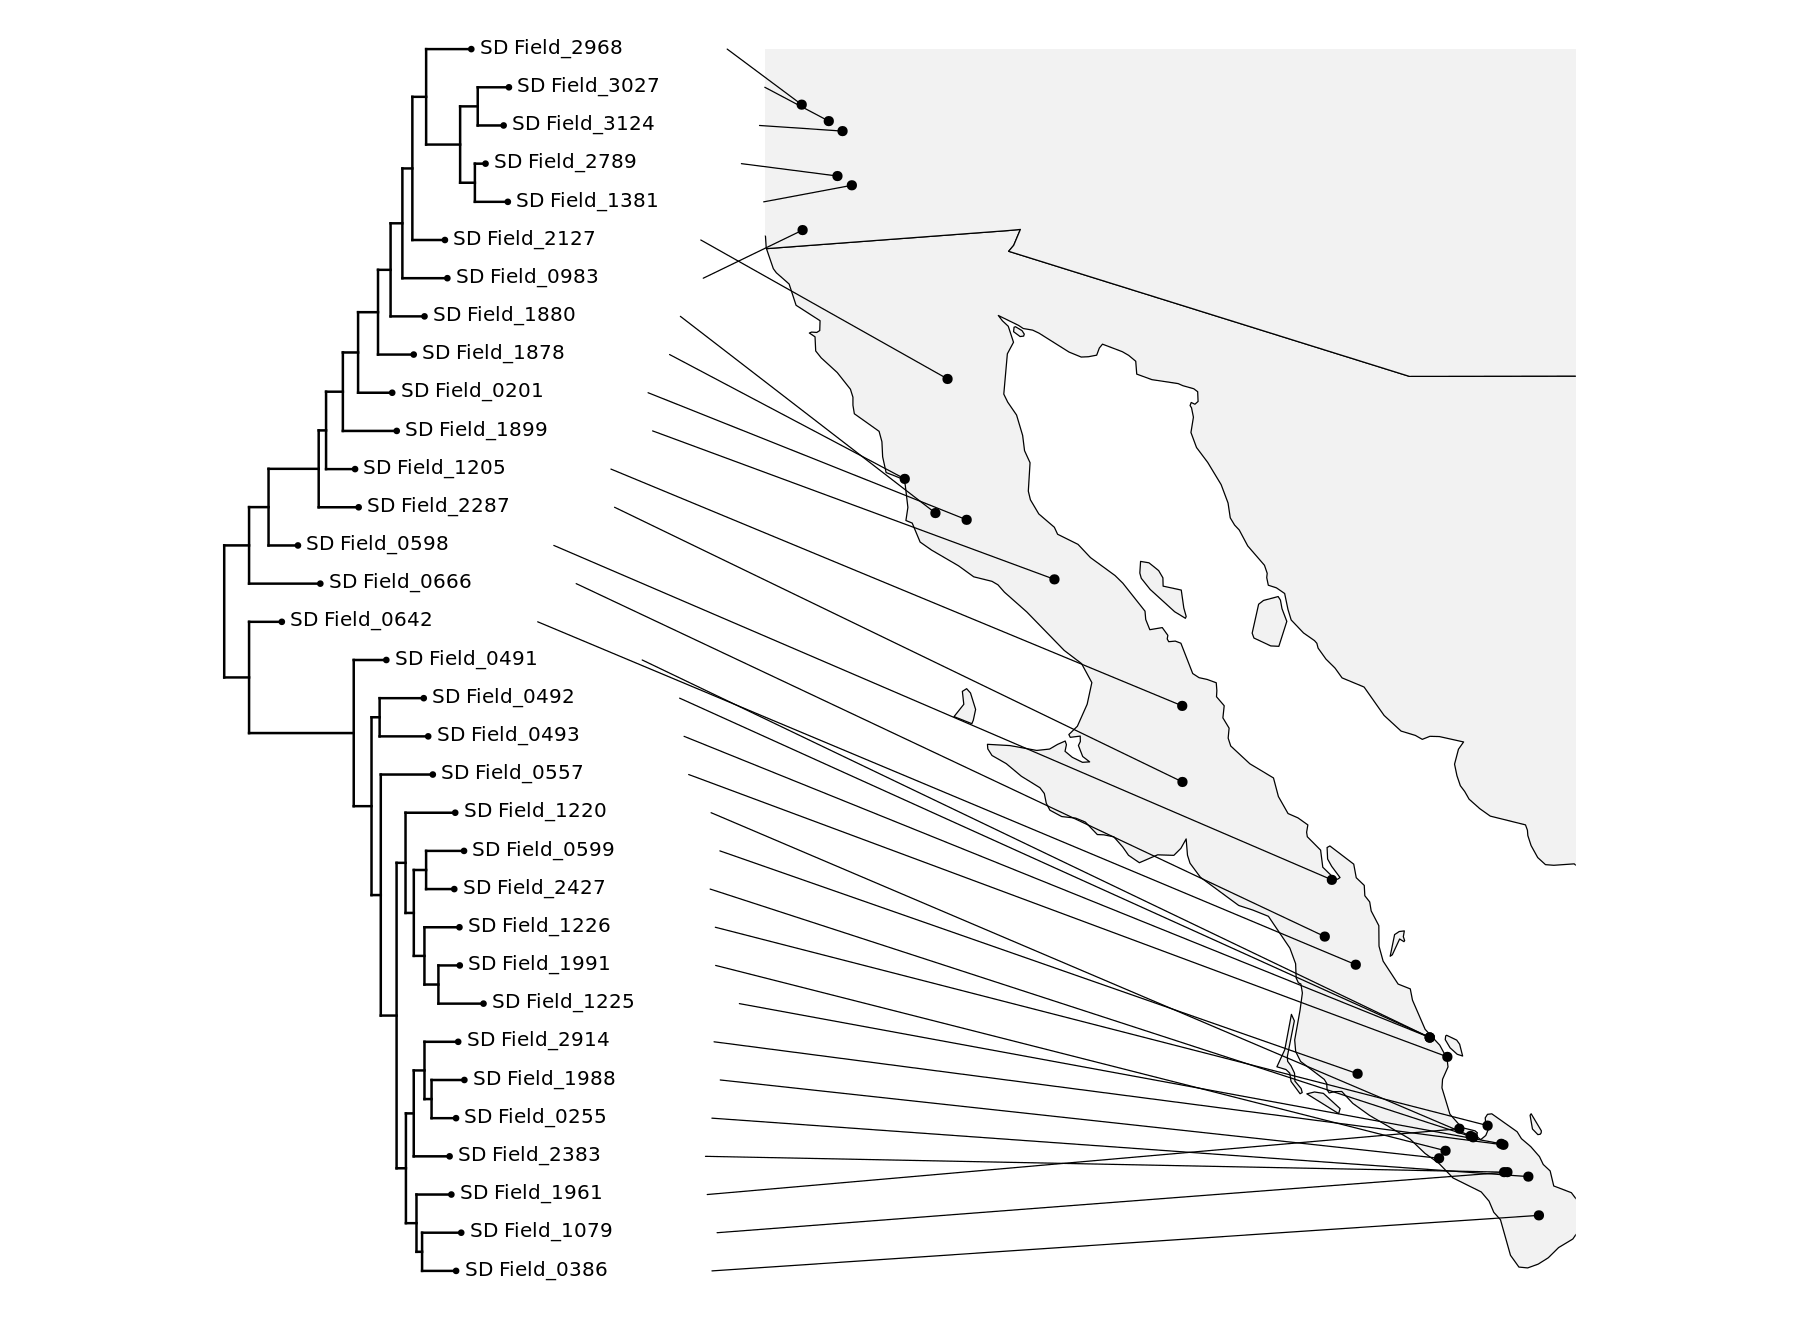

In [10]:
phylo.to.map(rooted_tree, tree_coords, direction = "rightwards", lty = "solid", colors = "black")

You should see something like this:



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/phymap2.png" width=50% />
</details>

<br>


There is a lot of other customization we could do here, but this is good enough for now. 



Feel free to look at the arguments to `phylo.to.map` and play around with them until you are satisfied.

In [11]:
html_content<-readr::read_file("quizzes/submodule_4/quiz1.html")
display_html(html_content)

Look at the phylo.to.map documentation here . What argument would you edit to plot the tree directly on the map, instead of above or on the side?
 
 
 
 direction="rightwards"
 
 
 ftype="i"
 
 
 delimit_map=TRUE
 
 
 type="direct"



### Adding SNMF results


We can also add in pie charts to show the population membership as inferred by SNMF from our previous tutorial to show multiple results on the same figure. Because we're using base R to plot this map, we'll have to use a different approach to plotting pies here instead of the `ggplot`/`scatterpie` approach we used when plotting SNMF pies on maps before.

In [12]:
# load up SNMF project

# set the path to the snmf project
snmf_proj_path <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/ipyrad_out/ruber_reduced_denovo_outfiles/ruber_reduced_denovo.u.snmfProject"


# load the snmf project
obj.at <- load.snmfProject(snmf_proj_path)


# set a value of k, the number of clusters, we want to use 2 here
k <- 2


# confirm cross entropy values for K are consist. across runs
ce <- cross.entropy(obj.at, K = k) 
best.run <- which.min(ce) # find the run with the lowest cross validation error
    
## Get the snmf Q matrix from the best run at the best k
qmatrix <- Q(obj.at, K = k, run = best.run)
admix <- as.data.frame(qmatrix)


# read in the vcf file to get the order of the individual names from ipyrad to make sure we can match these up to the SNMF qmatrix correctly
path_vcf <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/ipyrad_out/ruber_reduced_denovo_outfiles/ruber_reduced_denovo.vcf"

gendata_all <- read.vcfR(path_vcf) # read in all of the genetic data from the vcf file
gendata <- vcfR2genind(gendata_all) # convert to genind format
ind_names <- rownames(gendata@tab)

match_coords <- match(ind_names, coords[,"Field.No."])
snmf_coords <- coords[match_coords,]

# get the coordinate and admix data into a single dataframe to plot out these proportions on a map
for_pies <- cbind(snmf_coords, admix)


Scanning file to determine attributes.
File attributes:
  meta lines: 10
  header_line: 11
  variant count: 2885
  column count: 42
Meta line 10 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 2885
  Character matrix gt cols: 42
  skip: 0
  nrows: 2885
  row_num: 0
Processed variant: 2885
All variants processed


Loading required namespace: adegenet



objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 72

objective: 72

objective: 72

objective: 70

objective: 70

objective: 70

objective: 70

objective: 68

objective: 68

objective: 68

objective: 66

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 54

objective: 42

objective: 42

objective: 34

objective: 34

objective: 34

objective: 34

objective: 32



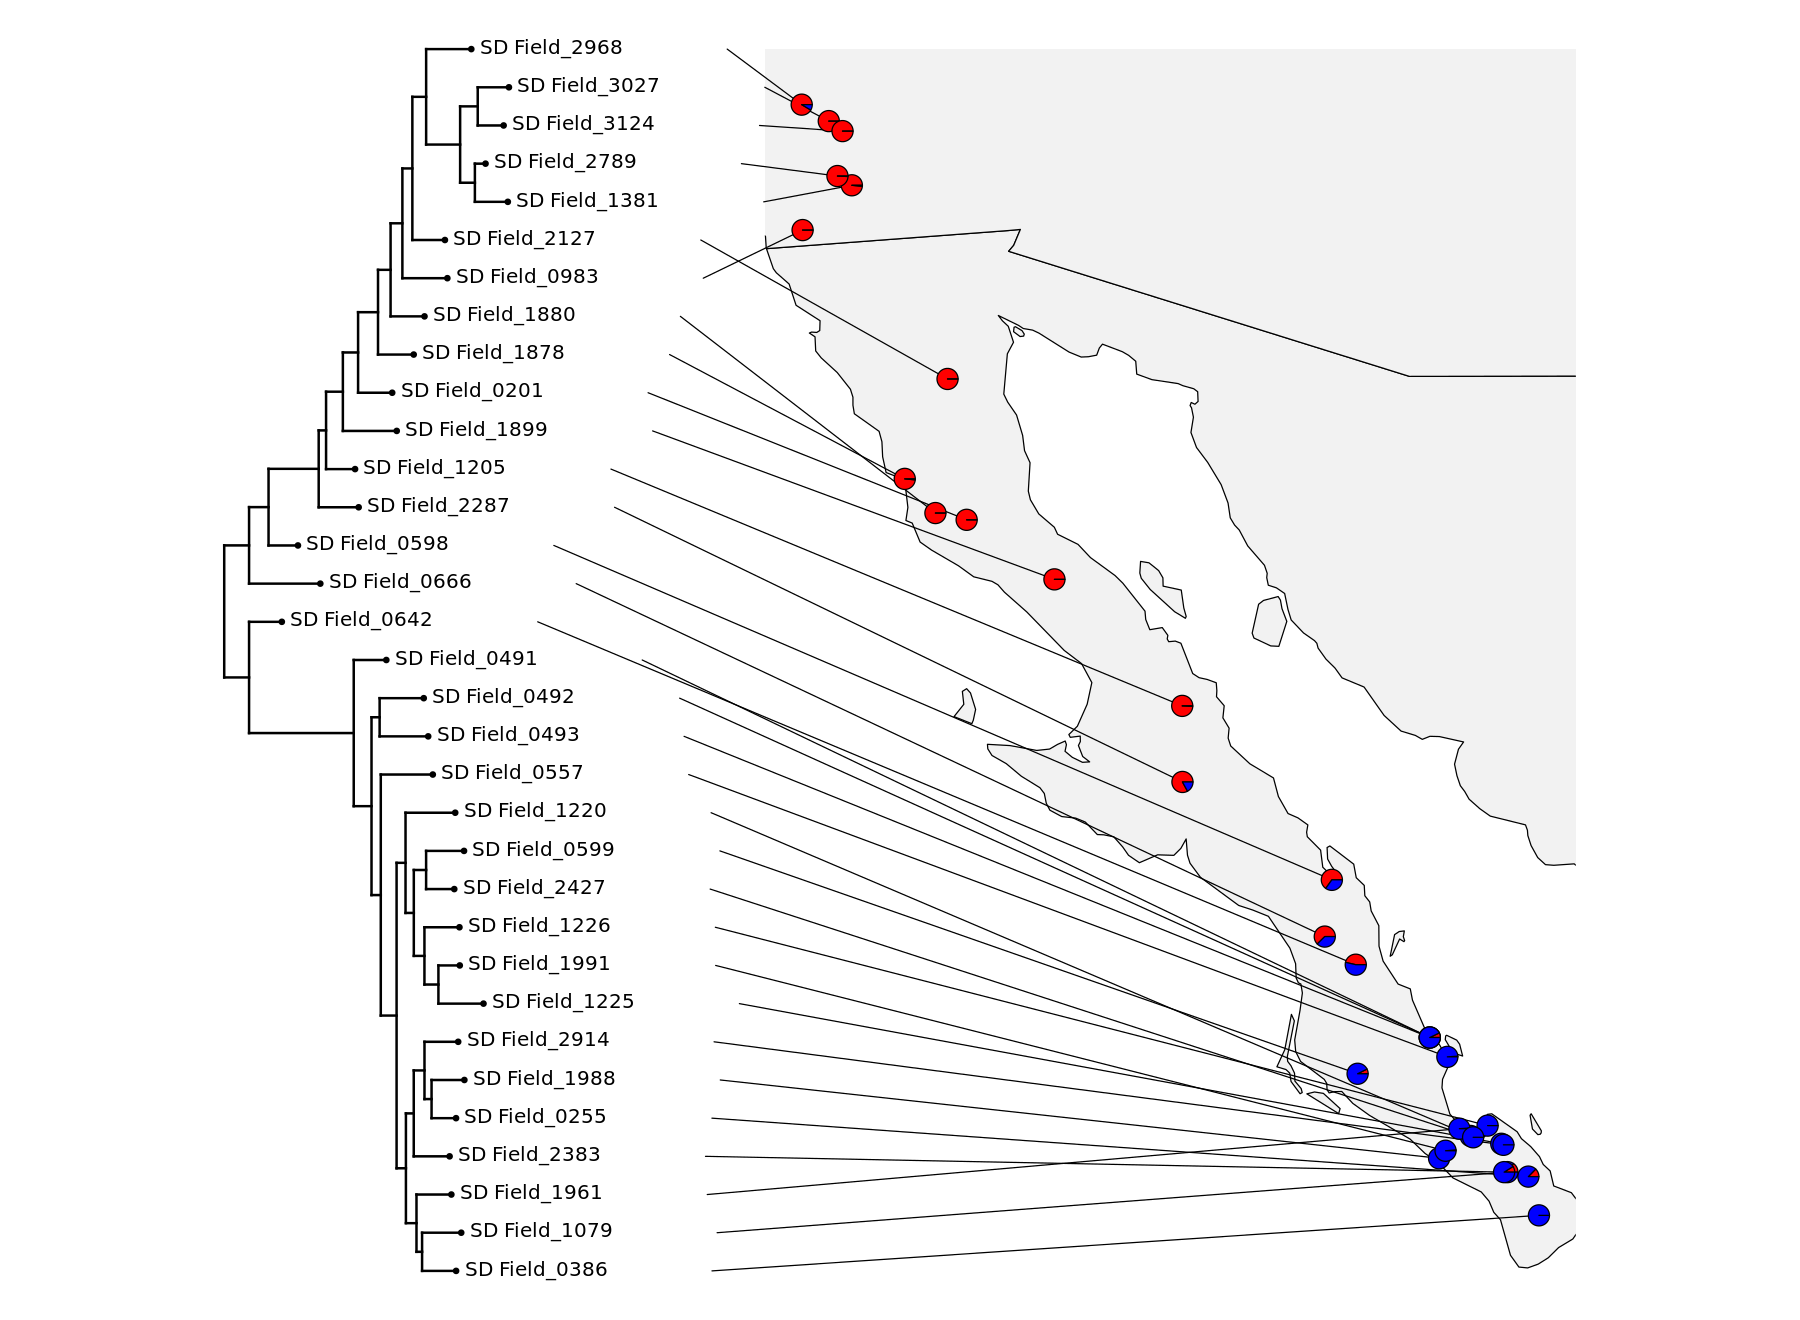

In [13]:
# The tree map
phylo.to.map(rooted_tree, tree_coords, direction = "rightwards", lty = "solid", colors = "black")

# Add pies
for (i in 1:nrow(for_pies)) {
  x <- for_pies$Longitude[i] # set the longitude
  y <- for_pies$Latitude[i] # set the latitude
  proportions <- c(for_pies$V1[i], for_pies$V2[i])  # Proportions from the admixture matrix
  pie_colors <- c("red", "blue")  # set colors
  
  # Use floating.pie to add the pie chart at each coordinate
  floating.pie(xpos = x, ypos = y, radius = 0.1, x = proportions, col = pie_colors)
}

Your plot should look like this:


<details>
  <summary>Click to show expected plot</summary>
  <img src="images/phymap3.png" width=60% />
</details>


<br>

This looks pretty good and conveys a lot of information, including the concordance between the phylogenetic tree and the SNMF population clustering results. 


* Note that using base R to plot the pies with the tree is not as clean or programmatic as the ggplot method we used for just plotting pies onto a map. There are a couple of objects that are currently hard coded for only two populations.


In [14]:
html_content<-readr::read_file("quizzes/submodule_4/quiz2.html")
display_html(html_content)

In the loop to add the pies (`for (i in 1:nrow(for_pies)) {`), which lines would you have to edit if you were plotting pies with more than 2 population clusters?
 
 
 
 x <- for_pies\$Longitude[i]
 
 
 y <- for_pies\$Latitude[i]
 
 
 proportions <- c(for_pies\$V1[i], for_pies\$V2[i])
 
 
 pie_colors <- c("red", "blue")
 
 Submit

To really get the spacing right and a figure that's ready for publication, we can plot it to pdf that you can open and download as you like:

In [15]:
# Plot it to a pdf now that it's dialed in:

pdf(file = "pie_map.pdf", width = 14, height = 10) # open the pdf plotting device

phylo.to.map(rooted_tree, tree_coords, direction = "rightwards", lty = "solid", colors = "black")

# Add pies using floating.pie() with add = TRUE
for (i in 1:nrow(for_pies)) {
  x <- for_pies$Longitude[i]
  y <- for_pies$Latitude[i]
  proportions <- c(for_pies$V1[i], for_pies$V2[i])  # Proportions from the admixture matrix
  pie_colors <- c("red", "blue")  # Modify colors based on your data
  
  # Use floating.pie to add the pie chart at each coordinate
  floating.pie(xpos = x, ypos = y, radius = 0.1, x = proportions, col = pie_colors)
}
dev.off() # close the plotting device

objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 74

objective: 72

objective: 72

objective: 72

objective: 70

objective: 70

objective: 70

objective: 70

objective: 68

objective: 68

objective: 68

objective: 66

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 64

objective: 54

objective: 42

objective: 42

objective: 34

objective: 34

objective: 34

objective: 34

objective: 32



pdf 
  2

<br>
<br>
<br>

## SVDQuartets

After an initial step, we can do all the same plotting with the SVDQuartets tree as we did for IQ-TREE, but we won't bother to repeat all of the same things.



Before we plot out the tree, we have to do some special manipulation with our SVDQuartets tree to get the bootstrap values at the nodes.

We'll go through this interactively here, but I have also included a script `bootanno.R` which can be run from the command line non-interactively like so: `Rscript bootanno.R filename.besttree.tre filename.svdqboots.tre`. Where the arguments are the file containing the best tree and the file containing the bootstrap trees, in that order.

In [16]:
#specify file paths to the best tree and set of bootstrap trees from SVDQuartets
best.tree.file <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/svdq_out/ruber_reduced_denovo.besttree.tre" # best tree from SVDQ
boot.file <-  "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/svdq_out/ruber_reduced_denovo.svdqboots.tre" #file of bootstrap trees from PAUP


# read the best tree and bootstrap trees into R
boottrees <- read.nexus(boot.file) 
besttree<- read.nexus(best.tree.file)

# Calculate the bootstrap proportions for each node in the best tree
boot <- prop.clades(besttree, boottrees) #calculates bootstrap support on each branch (not nodes because it's unrooted)
boot[is.na(boot)] <- 0 #replace NAs with 0
numboots <- length(boottrees) # nreps of bootstrapping
bootprop <- round((boot/numboots)*100, digits = 2) # gives a percentage of bootstrap support

besttree$node.label <- bootprop #p ut bootstrap values on nodes of the tree
write.tree(besttree, file=gsub(".tre$", "_boot.tre", best.tree.file)) # write new tree file with same name as the best tree with "_boot.tre" added to end
 

Now that we have the best tree with bootstraps added onto it, we can plot this out. We could plot this tree to a map and add the pies just the same as we did with the tree from IQtree, but we'll skip that since we already demonstrated it.

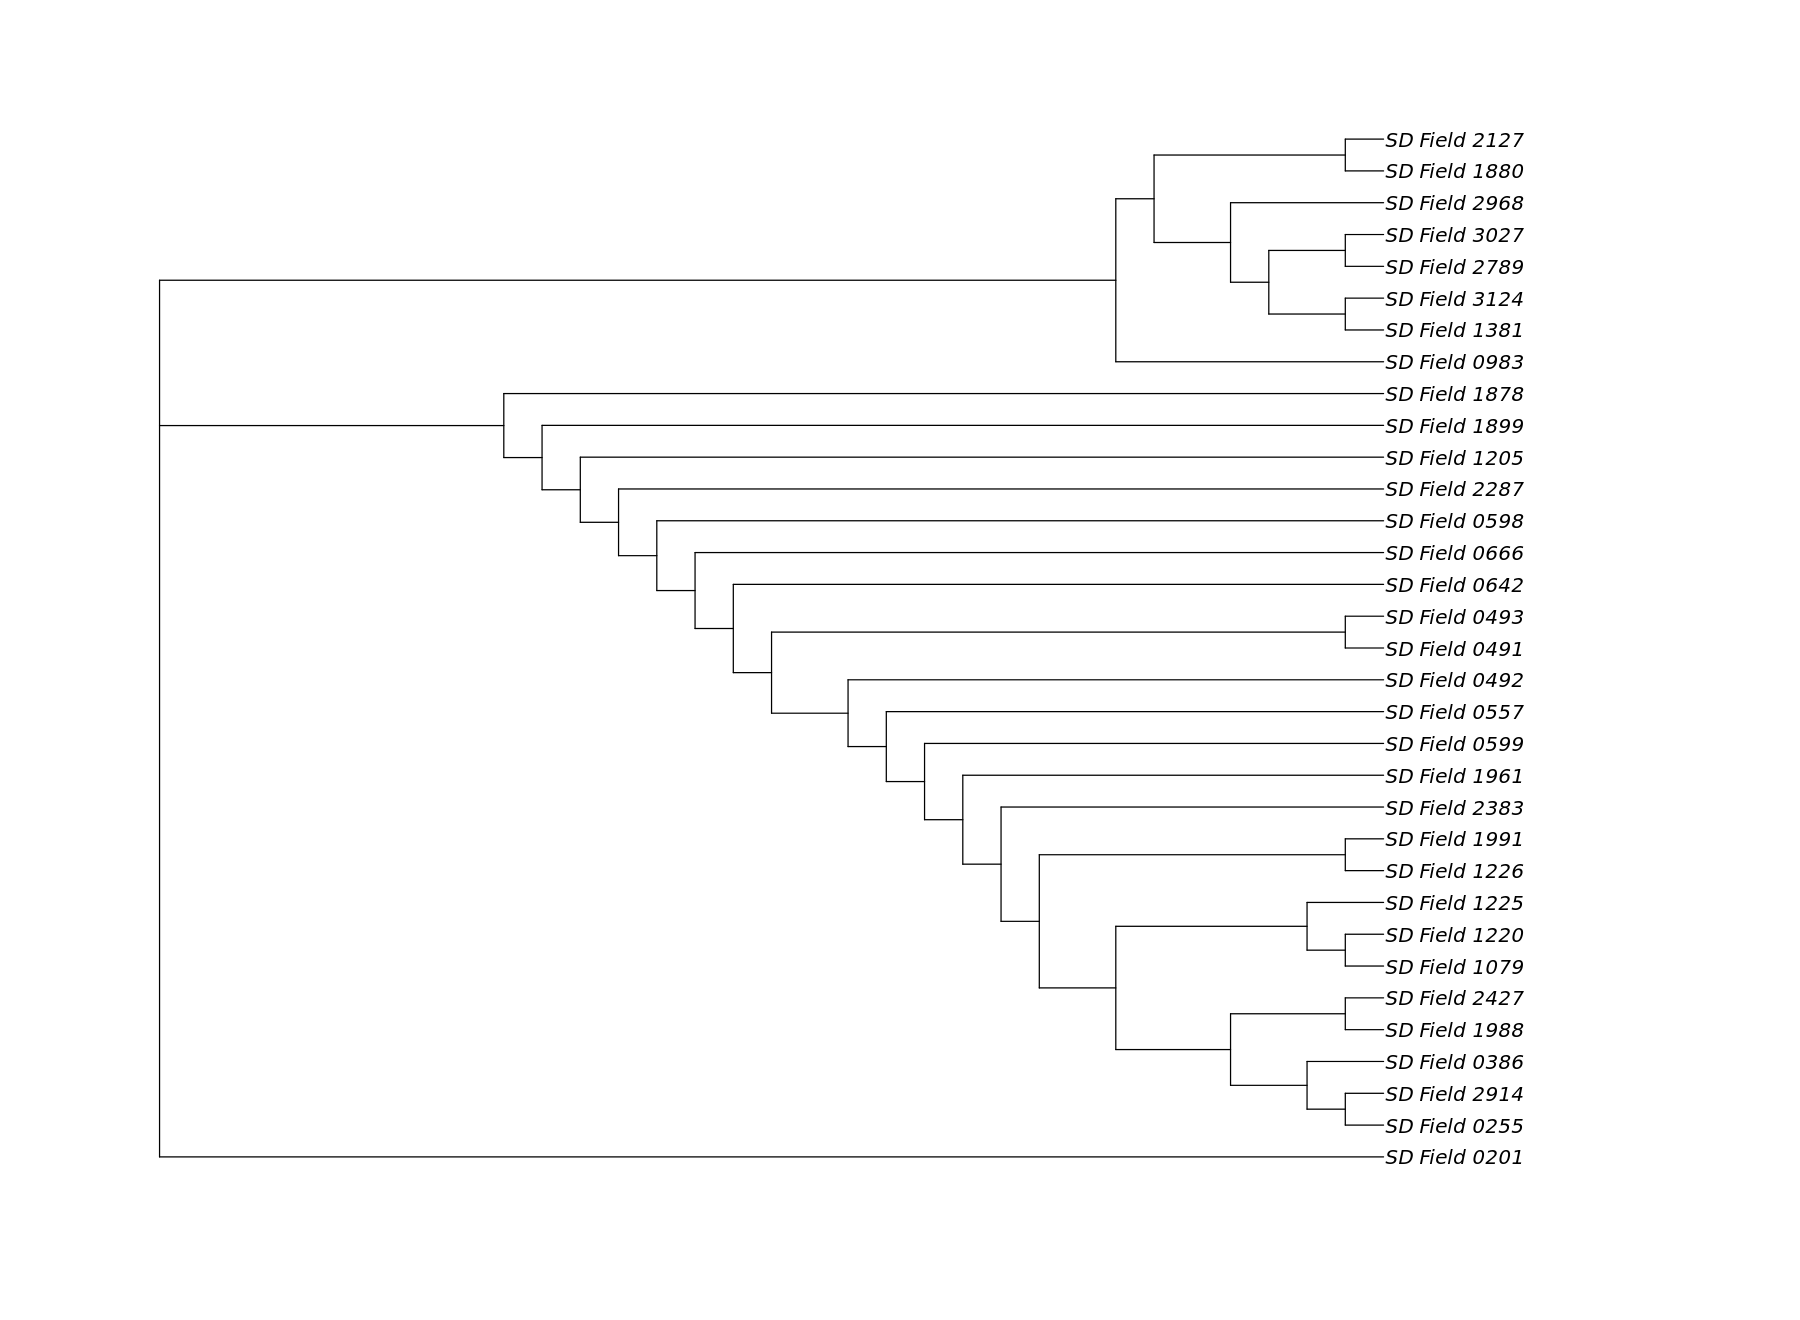

In [17]:
# path to best tree with boostraps file:
svdq_file <- "/home/jupyter/Population-Genomics-and-Phylogenetics-with-RADseq/svdq_out/ruber_reduced_denovo.besttree_boot.tre"


#plot the SVDQuartets tree

svdq_tree <- read.tree(svdq_file)

# Use functions from ape to plot the tree

plot.phylo(svdq_tree) # plot the tree

Your plotted tree should look like this:



<details>
  <summary>Click to show expected plot</summary>
  <img src="images/svdq1.png" width=40% />
</details>


<br>

Note a couple of important things:



1. This tree does not have branch lengths, and so they are displayed arbitrarily. This is because SVDQuartets does not use a substitution model like IQTree does, and so does not estimate branch lengths in substitutions.

2. Our tree is again unrooted, and we'll have to root this like we did with the IQtree.

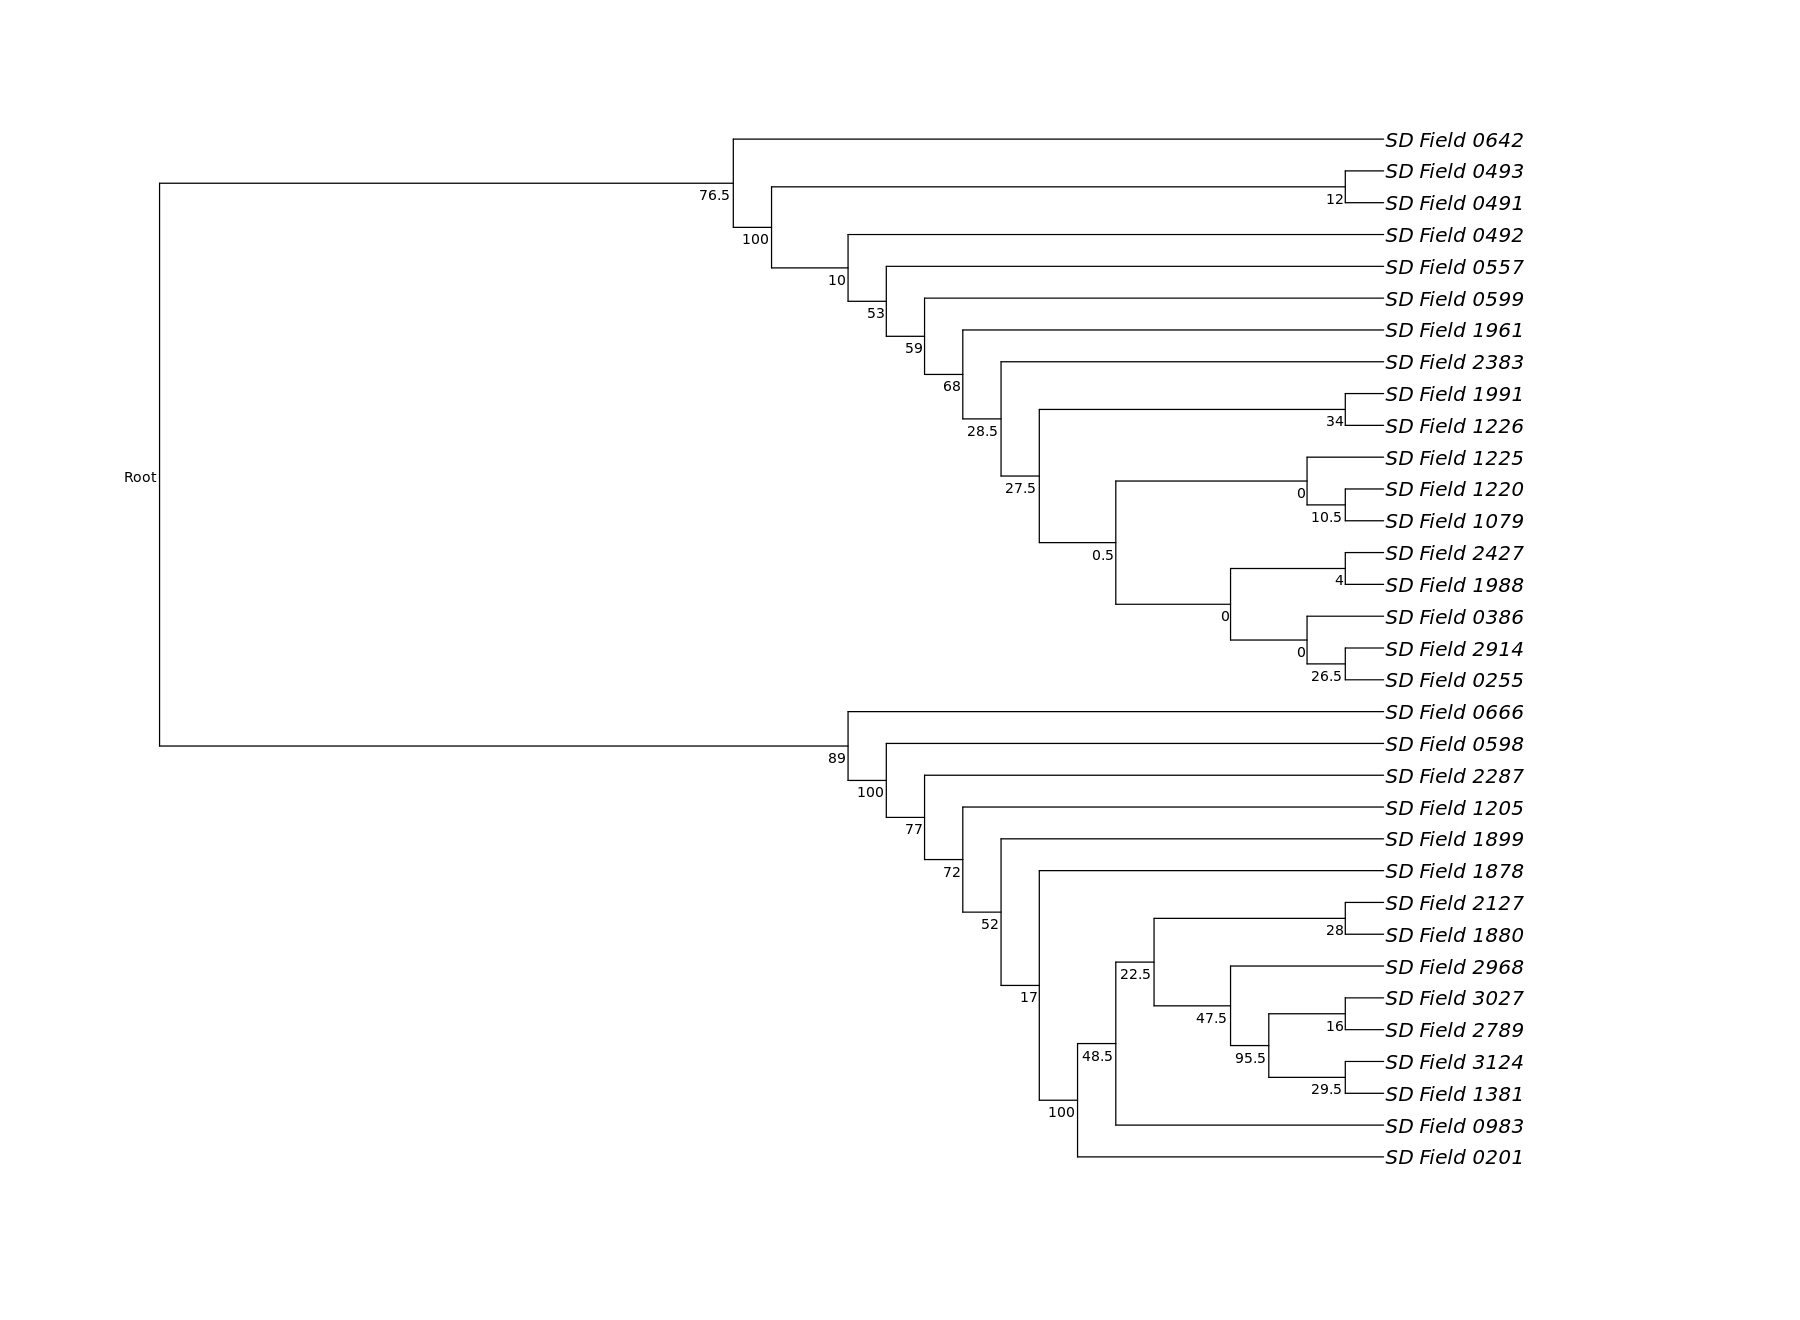

In [18]:
# Specify the taxa for the "outgroup"
taxa <- c("SD_Field_0642", "SD_Field_0255")

# Get the MRCA node
mrca_node <- getMRCA(svdq_tree, taxa)

# Root the tree at the MRCA node
rooted_svdqtree <- root(svdq_tree, node = mrca_node, resolve.root = TRUE)


# Plot the rooted tree
plot(rooted_svdqtree)
# add on the bootstraps
nodelabels(text = rooted_svdqtree$node.label, adj = c(1.1, 1.7), cex = 0.7, frame = "none")

Notice that because there are no branch lengths, we didn't have to deal with editing the length of the branch at the root to distribute it among both daughter clades. We see that both trees have relatively low bootstrap support for many nodes, other than the major northern and southern groups of individuals. This is because within each clade, individuals are members of a population cluster that share genes, and are therefore not actually organized into a hierarchical tree structure.





<details>
  <summary>Click to show expected plot</summary>
  <img src="images/svdq2.png" width=70% />
</details>

<br>



If we want to see how the two trees differ from each (or don't), we can plot them facing each other with lines connecting the same individual in each tree using a phytools function:


Rotating nodes to optimize matching...
Done.


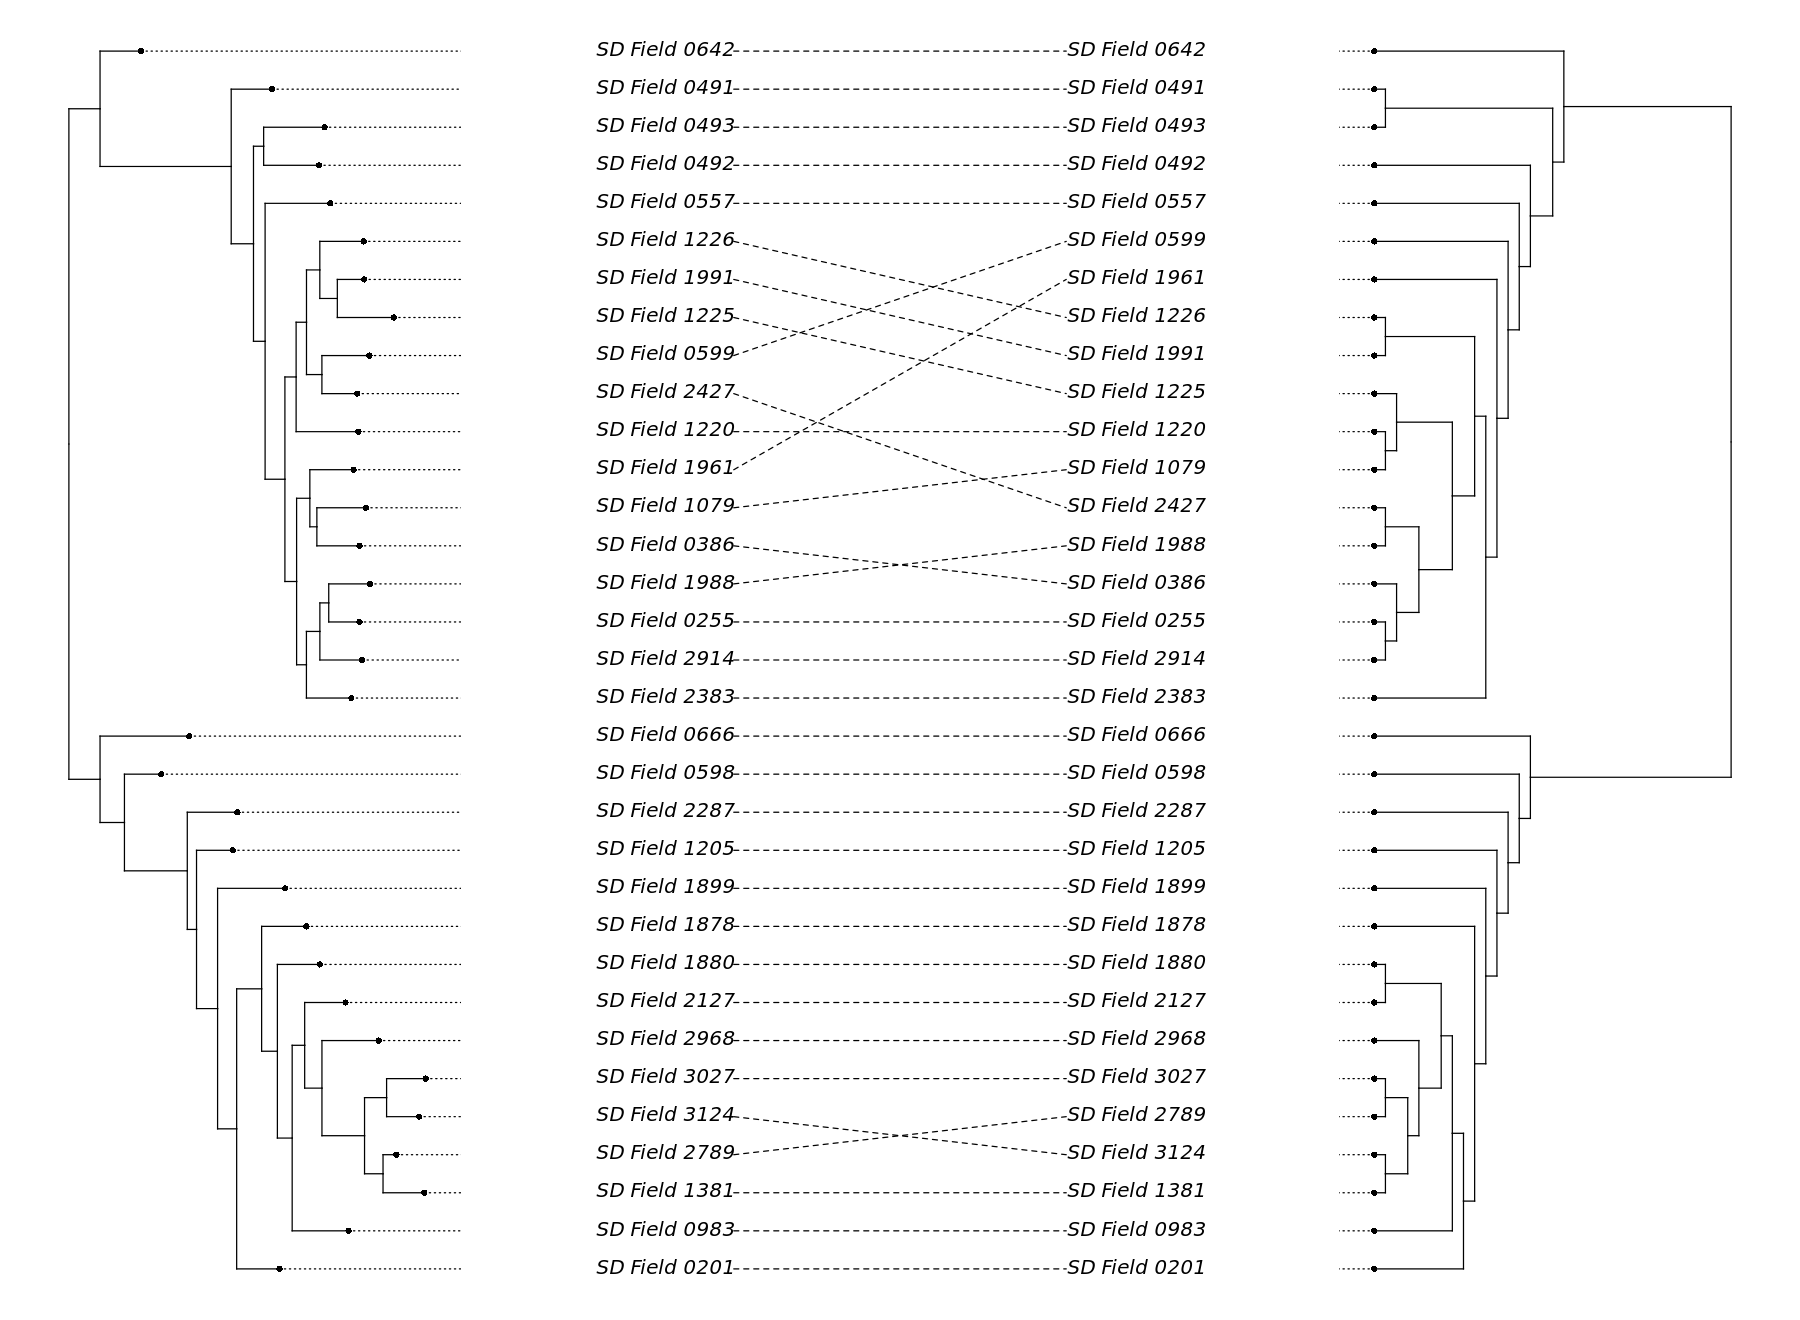

In [19]:
cophy <- cophylo(rooted_tree, rooted_svdqtree)
plot(cophy)

The trees are overall very similar, and really only differ in areas that have low support values, as we've plotted on the individual trees. 




<details>
  <summary>Click to show expected plot</summary>
  <img src="images/cophy1.png" width=70% />
</details>




<br>
<br>
<br>

We can also plot those values to make this clearer.

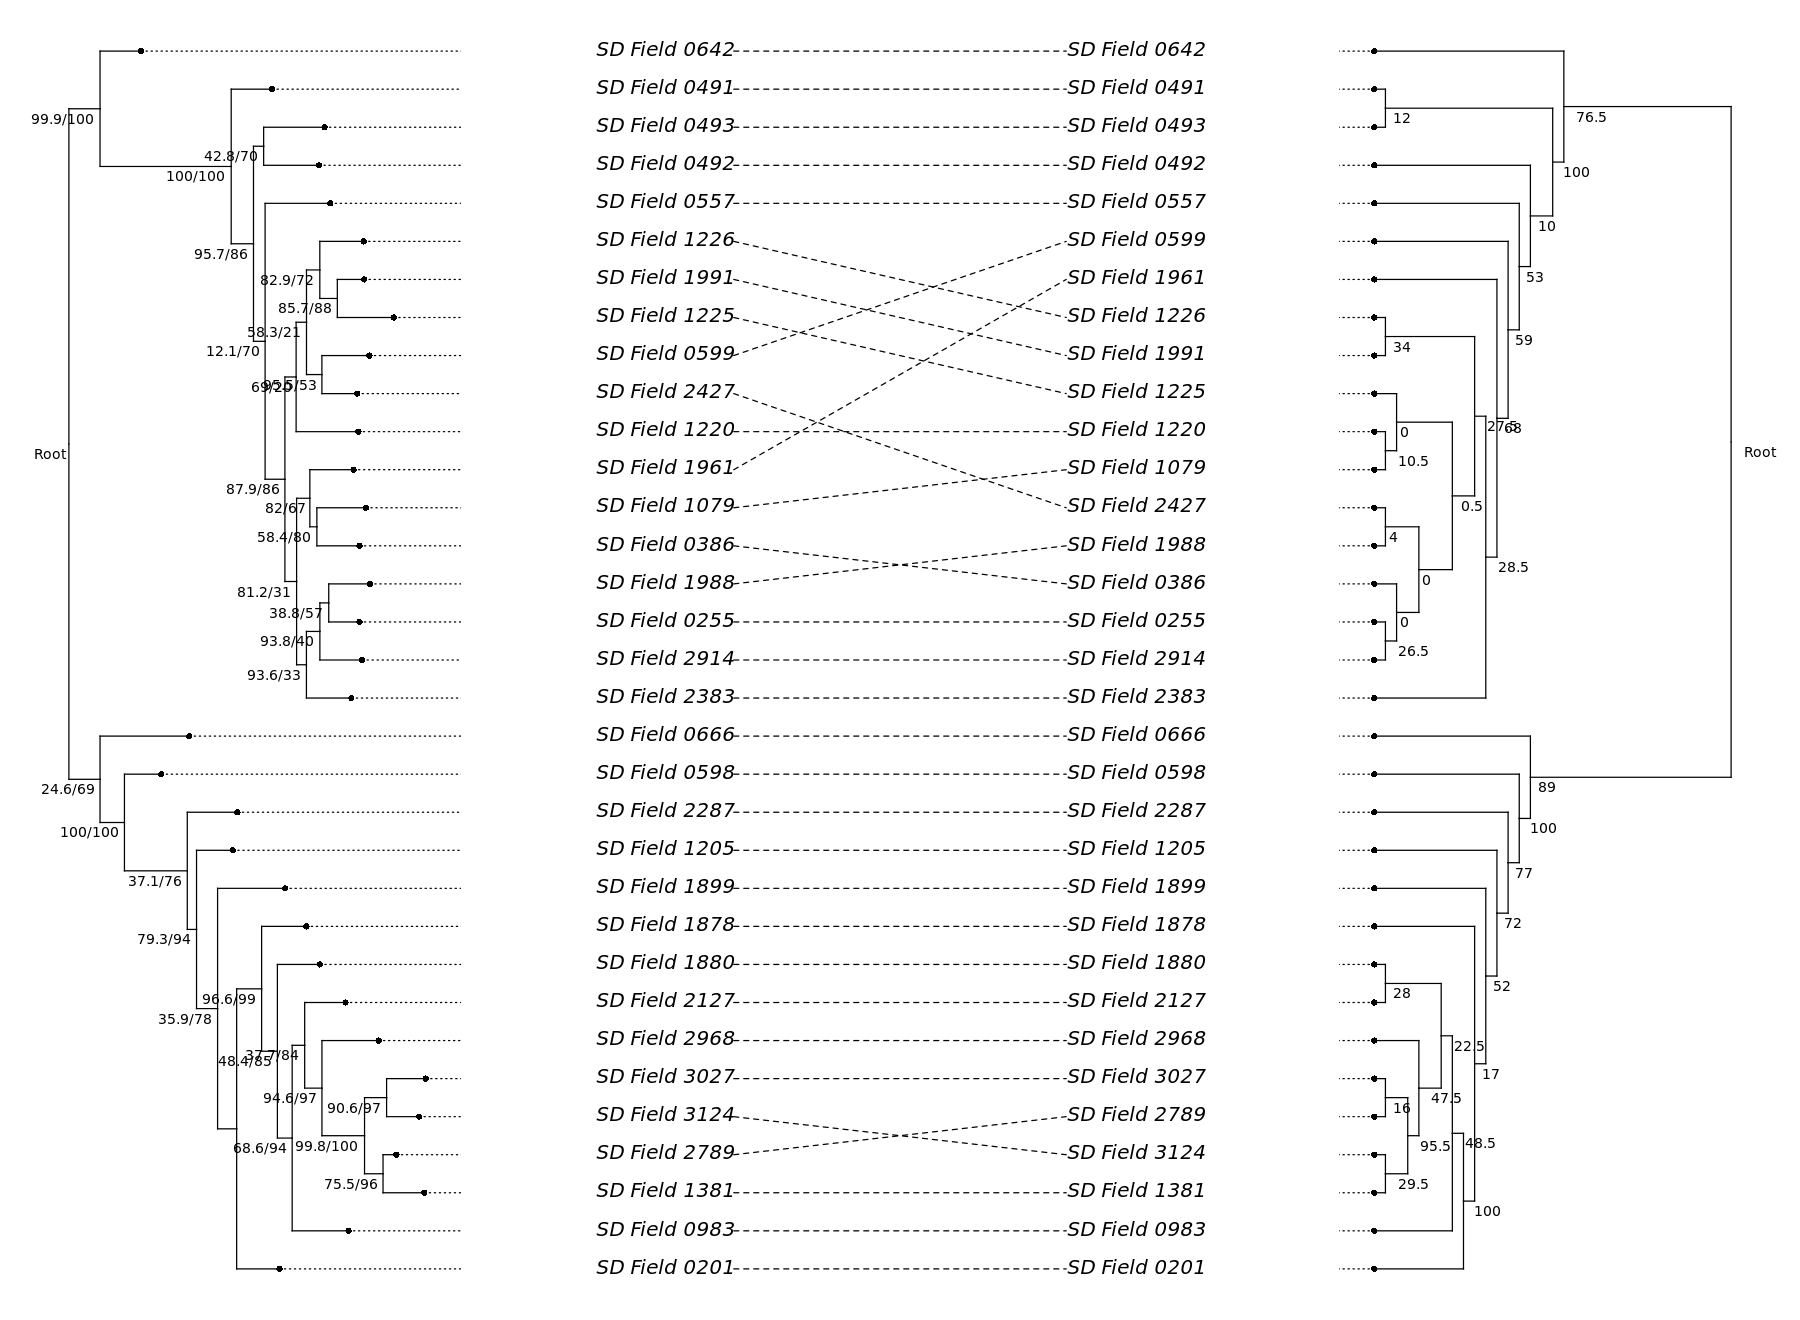

In [20]:
plot(cophy)

## show support values at node labels:
nodelabels.cophylo(cophy$trees[[1]]$node.label, cex = 0.7,
    frame = "none", adj = c(1.1, 1.5))
nodelabels.cophylo(cophy$trees[[2]]$node.label, cex = 0.7,
    frame = "none",adj = c(-0.4, 1.5), which="right")


In [21]:
# plot the same to pdf

pdf(file = "../cophy.pdf", width = 20, height = 13)

plot(cophy)

## show support values at node labels:
nodelabels.cophylo(cophy$trees[[1]]$node.label, cex = 0.7,
    frame = "none", adj = c(1.1, 1.5))
nodelabels.cophylo(cophy$trees[[2]]$node.label, cex = 0.7,
    frame = "none",adj = c(-0.4, 1.5), which="right")

dev.off()



pdf 
  2




<details>
  <summary>Click to show expected plot</summary>
  <img src="images/cophy2.png" width=70% />
</details>


<br>
<br>




# Conclusion

In this tutorial, we used R to make high-quality plot of the results from the phylogenetic analyses that we ran in the previous tutorial. We also combined these results with the population genetic clustering results from tutorial 2 to create a single map figure that shows phylogenetic and population genetic results. These methods should enable you to make publication-quality figures, and there are many ways to customize these plots beyond what we've demonstrated here. There are also many other ways to visualize trees beyond the couple of `ape` and `phytools` functions we've shown here. `Phytools` has many other functions for plotting phylogenies and data and there is also the package `ggtree`, which extends the functionality of the popular `ggplot2` package and allows very fine control of plotting parameters. 



<br>

# Cleanup

This is the end of the entire module! When you're finished, shut down your GCP instance to prevent being charged while it sits idle.


